In [1]:
# Python
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from prophet import Prophet
import mysql
import mysql.connector
import pymysql
import joblib
import dyplot
from datetime import datetime
from sklearn.metrics import mean_absolute_error


In [2]:
query = f"""SELECT fecha,tmed
FROM valores_climatologicos
"""

In [3]:
database = "AEMET"

db = mysql.connector.connect(host     = "localhost",
                             user     = "root",
                             password = "nueva_contraseña",
                             database = database)

cursor = db.cursor()

cursor.execute(query) # Ejecutamos la query
column_names = cursor.column_names # Nombre de las columnas de la tabla

# Guardamos los datos de la tabla
data = cursor.fetchall()


df = pd.DataFrame(data, columns = column_names)

cursor.close()
db.close()

In [4]:
df["fecha"] = pd.to_datetime(df["fecha"])


# SEMESTRAL:

In [6]:
df['semestre'] = df['fecha'].apply(lambda x: pd.Timestamp(year=x.year, month=(1 if x.month <= 6 else 7), day=1))
df["semestre"].unique()

<DatetimeArray>
['2013-01-01 00:00:00', '2013-07-01 00:00:00', '2014-01-01 00:00:00',
 '2014-07-01 00:00:00', '2015-01-01 00:00:00', '2015-07-01 00:00:00',
 '2017-01-01 00:00:00', '2017-07-01 00:00:00', '2018-01-01 00:00:00',
 '2018-07-01 00:00:00', '2019-01-01 00:00:00', '2019-07-01 00:00:00',
 '2020-01-01 00:00:00', '2020-07-01 00:00:00', '2021-01-01 00:00:00',
 '2021-07-01 00:00:00', '2022-01-01 00:00:00', '2022-07-01 00:00:00',
 '2023-01-01 00:00:00', '2023-07-01 00:00:00', '2024-01-01 00:00:00',
 '2024-07-01 00:00:00', '2016-01-01 00:00:00', '2016-07-01 00:00:00']
Length: 24, dtype: datetime64[ns]

In [7]:
df_biannual = df.groupby("semestre").agg({"tmed":"mean"}).reset_index()

In [8]:
df_biannual

,semestre,tmed
0,2013-01-01,11.939553
1,2013-07-01,17.126592
2,2014-01-01,13.323046
3,2014-07-01,17.316944
4,2015-01-01,13.221510
5,2015-07-01,17.887790
6,2016-01-01,12.880579
7,2016-07-01,17.641331
8,2017-01-01,13.928824
9,2017-07-01,17.359126


In [9]:
def preparar_data(df,column1, column2):

    df = df[[column1, column2]]
    df.rename(columns={column1: "ds", column2: "y"}, inplace=True)
    
    return df

In [10]:
df_biannual = preparar_data(df_biannual,"semestre","tmed")

In [11]:
df_biannual

,ds,y
0,2013-01-01,11.939553
1,2013-07-01,17.126592
2,2014-01-01,13.323046
3,2014-07-01,17.316944
4,2015-01-01,13.221510
5,2015-07-01,17.887790
6,2016-01-01,12.880579
7,2016-07-01,17.641331
8,2017-01-01,13.928824
9,2017-07-01,17.359126


In [12]:
#MODELO

m = Prophet()
m.fit(df_biannual)

12:54:49 - cmdstanpy - INFO - Chain [1] start processing
12:54:49 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
joblib.dump(m, 'prophet_biannual.pkl')

print("Modelo guardado con joblib")

Modelo guardado con joblib


In [14]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
384,2025-06-27
385,2025-06-28
386,2025-06-29
387,2025-06-30
388,2025-07-01


In [15]:
forecast_biannual = m.predict(future)
forecast_biannual[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
384,2025-06-27,48.242059,47.433808,49.003801
385,2025-06-28,35.108410,34.357962,35.922530
386,2025-06-29,25.742725,24.971467,26.529268
387,2025-06-30,20.420715,19.700914,21.190025
388,2025-07-01,19.304242,18.550398,20.151378


/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


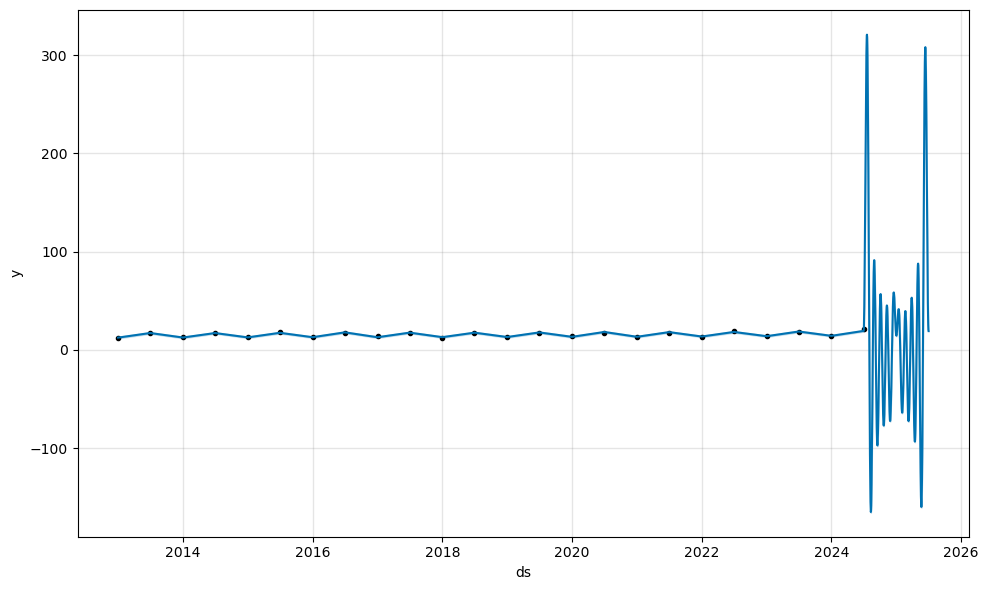

In [16]:
# Graficar usando Prophet
fig1 = m.plot(forecast_biannual)

# Mostrar la gráfica
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

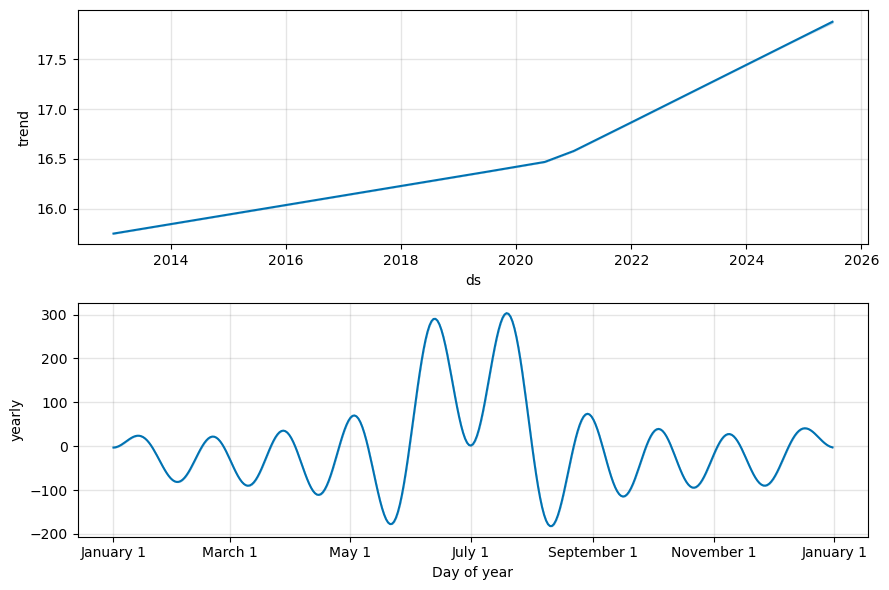

In [17]:
fig2 = m.plot_components(forecast_biannual)

# TRIMESTRAL:

In [19]:
df['trimestre'] = df['fecha'].dt.to_period('Q').apply(lambda r: r.start_time)

In [20]:
df["trimestre"]

0         2013-01-01
1         2013-01-01
2         2013-01-01
3         2013-01-01
4         2013-01-01
             ...    
7336000   2024-10-01
7336001   2024-10-01
7336002   2024-10-01
7336003   2024-10-01
7336004   2024-10-01
Name: trimestre, Length: 7336005, dtype: datetime64[ns]

In [21]:
df_quarterly = df.groupby("trimestre").agg({"tmed":"mean"}).reset_index()
df_quarterly

,trimestre,tmed
0,2013-01-01,8.819638
1,2013-04-01,15.011527
2,2013-07-01,22.414274
3,2013-10-01,11.868290
4,2014-01-01,9.551493
5,2014-04-01,16.970295
6,2014-07-01,21.681875
7,2014-10-01,12.966418
8,2015-01-01,8.788659
9,2015-04-01,17.586427


In [22]:
df_quarterly = preparar_data(df_quarterly,"trimestre","tmed")
df_quarterly

,ds,y
0,2013-01-01,8.819638
1,2013-04-01,15.011527
2,2013-07-01,22.414274
3,2013-10-01,11.868290
4,2014-01-01,9.551493
5,2014-04-01,16.970295
6,2014-07-01,21.681875
7,2014-10-01,12.966418
8,2015-01-01,8.788659
9,2015-04-01,17.586427


In [23]:
#MODELO

m = Prophet()
m.fit(df_quarterly)

12:56:58 - cmdstanpy - INFO - Chain [1] start processing
12:56:59 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
joblib.dump(m, 'prophet_quarterly.pkl')

print("Modelo guardado con joblib")

Modelo guardado con joblib


In [25]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
408,2025-09-27
409,2025-09-28
410,2025-09-29
411,2025-09-30
412,2025-10-01


In [26]:
forecast_quarterly = m.predict(future)
forecast_quarterly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
408,2025-09-27,40.506419,39.676186,41.338336
409,2025-09-28,28.914503,28.104891,29.798095
410,2025-09-29,20.493160,19.641234,21.328287
411,2025-09-30,15.525794,14.641322,16.393688
412,2025-10-01,14.220547,13.422729,15.097965


/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


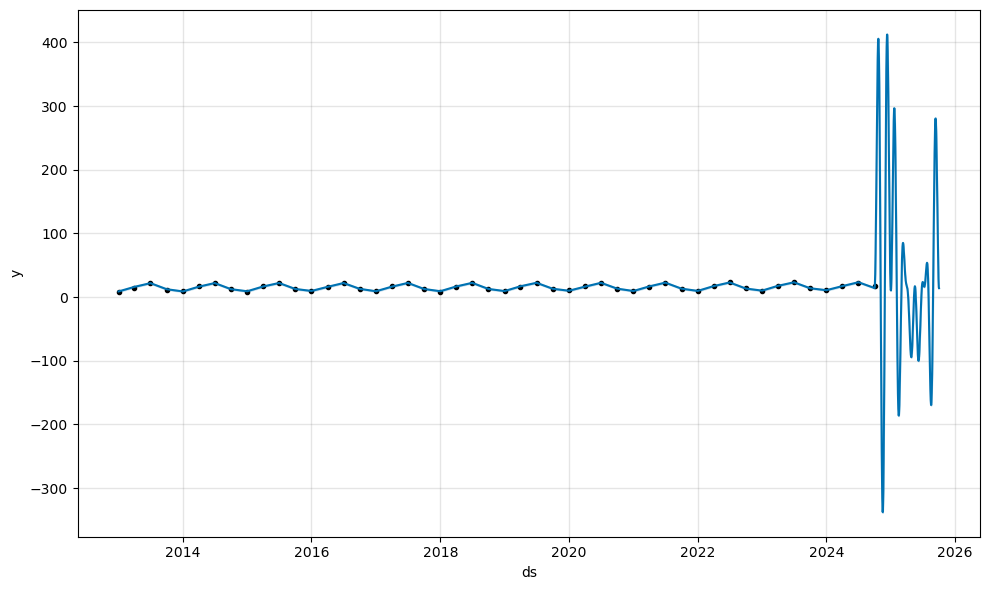

In [27]:
# Graficar usando Prophet
fig1 = m.plot(forecast_quarterly)

# Mostrar la gráfica
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

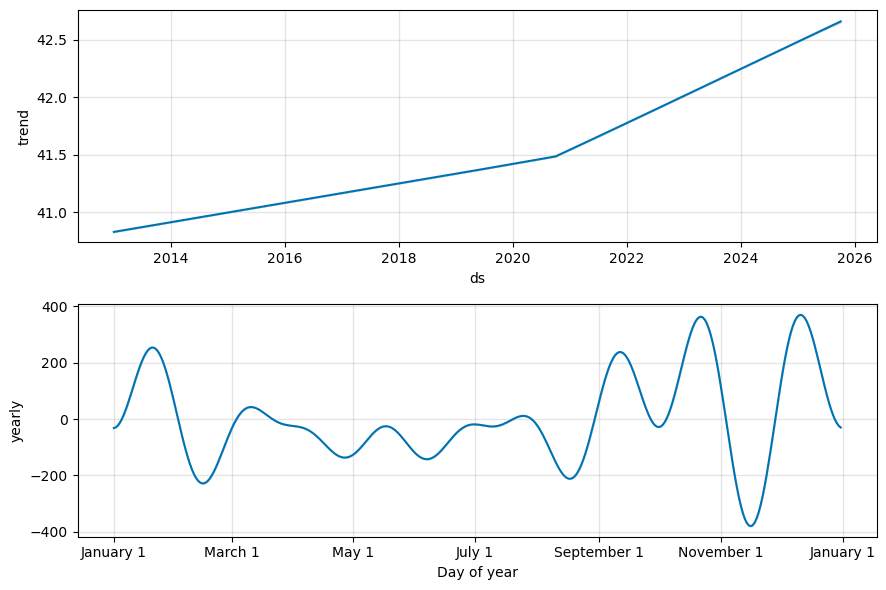

In [28]:
fig2 = m.plot_components(forecast_quarterly)

# MENSUAL:

In [30]:
df['mes'] = df['fecha'].dt.to_period('M').apply(lambda r: r.start_time)

In [31]:
df['mes']

0         2013-01-01
1         2013-01-01
2         2013-01-01
3         2013-01-01
4         2013-01-01
             ...    
7336000   2024-11-01
7336001   2024-11-01
7336002   2024-11-01
7336003   2024-11-01
7336004   2024-11-01
Name: mes, Length: 7336005, dtype: datetime64[ns]

In [32]:
df_monthly = df.groupby("mes").agg({"tmed":"mean"}).reset_index()
df_monthly

,mes,tmed
0,2013-01-01,8.371864
1,2013-02-01,7.588383
2,2013-03-01,10.365606
3,2013-04-01,12.464401
4,2013-05-01,13.957410
...,...,...
138,2024-07-01,24.036916
139,2024-08-01,24.672682
140,2024-09-01,19.162857
141,2024-10-01,16.764565


In [33]:
df_monthly = preparar_data(df_monthly,"mes","tmed")
df_monthly

,ds,y
0,2013-01-01,8.371864
1,2013-02-01,7.588383
2,2013-03-01,10.365606
3,2013-04-01,12.464401
4,2013-05-01,13.957410
...,...,...
138,2024-07-01,24.036916
139,2024-08-01,24.672682
140,2024-09-01,19.162857
141,2024-10-01,16.764565


In [34]:
#MODELO

m = Prophet()
m.fit(df_monthly)

12:59:06 - cmdstanpy - INFO - Chain [1] start processing
12:59:06 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
joblib.dump(m, 'prophet_monthly.pkl')

print("Modelo guardado con joblib")

Modelo guardado con joblib


In [36]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
503,2025-10-28
504,2025-10-29
505,2025-10-30
506,2025-10-31
507,2025-11-01


In [37]:
forecast_monthly = m.predict(future)
forecast_monthly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
503,2025-10-28,9.960163,8.636006,11.356764
504,2025-10-29,10.686704,9.424621,12.073897
505,2025-10-30,11.452233,10.057534,12.825732
506,2025-10-31,12.245516,10.823333,13.479598
507,2025-11-01,13.054774,11.670044,14.345218


/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


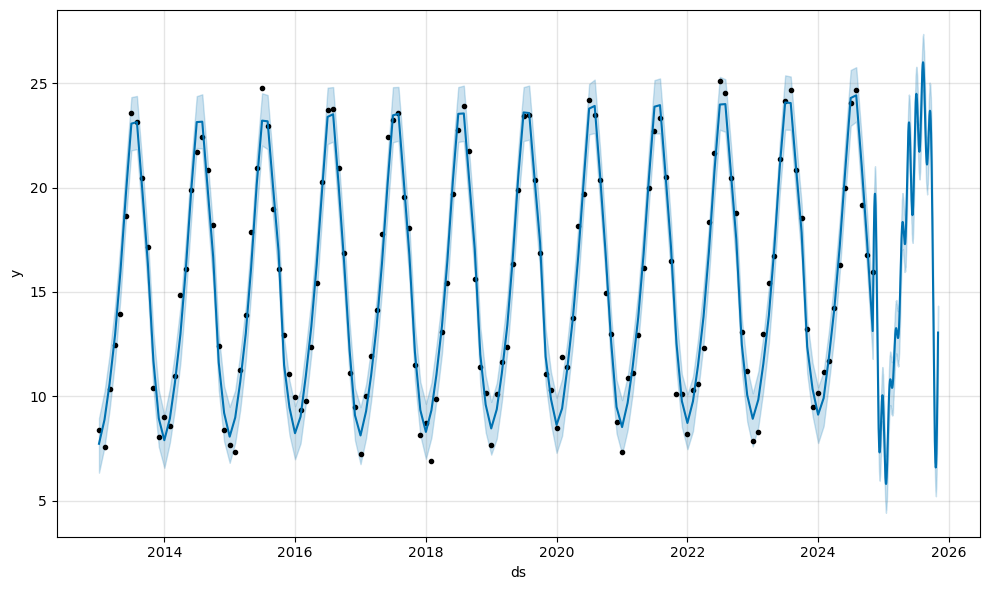

In [38]:
# Graficar usando Prophet
fig1 = m.plot(forecast_monthly)

# Mostrar la gráfica
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

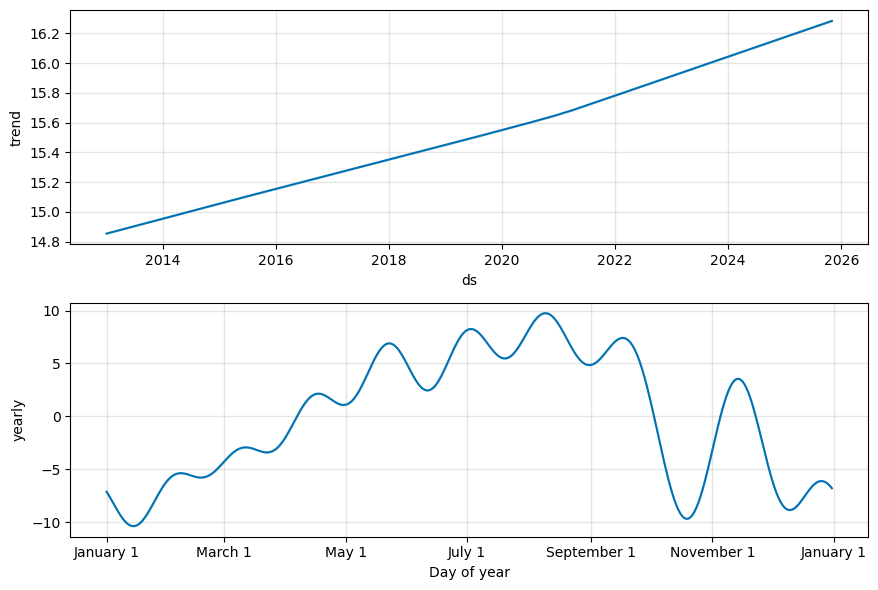

In [39]:
fig2 = m.plot_components(forecast_monthly)

# SEMANAL:

In [41]:
df['semana'] = df['fecha'].dt.to_period('W').apply(lambda r: r.start_time)

In [42]:
df_weekly = df.groupby("semana").agg({"tmed":"mean"}).reset_index()

In [43]:
df_weekly = preparar_data(df_weekly,"semana","tmed")
df_weekly

,ds,y
0,2012-12-31,8.512068
1,2013-01-07,7.987963
2,2013-01-14,8.433796
3,2013-01-21,7.484366
4,2013-01-28,9.582280
...,...,...
613,2024-09-30,19.037875
614,2024-10-07,17.418297
615,2024-10-14,17.105175
616,2024-10-21,15.004087


In [44]:
#MODELO

m = Prophet()
m.fit(df_weekly)

13:01:13 - cmdstanpy - INFO - Chain [1] start processing
13:01:13 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
joblib.dump(m, 'prophet_weekly.pkl')

print("Modelo guardado con joblib")

Modelo guardado con joblib


In [46]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
978,2025-10-24
979,2025-10-25
980,2025-10-26
981,2025-10-27
982,2025-10-28


In [47]:
forecast_weekly = m.predict(future)
forecast_weekly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
978,2025-10-24,15.963497,13.856864,18.041709
979,2025-10-25,15.795046,13.923717,17.826745
980,2025-10-26,15.627986,13.532531,17.733087
981,2025-10-27,15.462085,13.411818,17.500505
982,2025-10-28,15.297016,13.221600,17.475682


/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


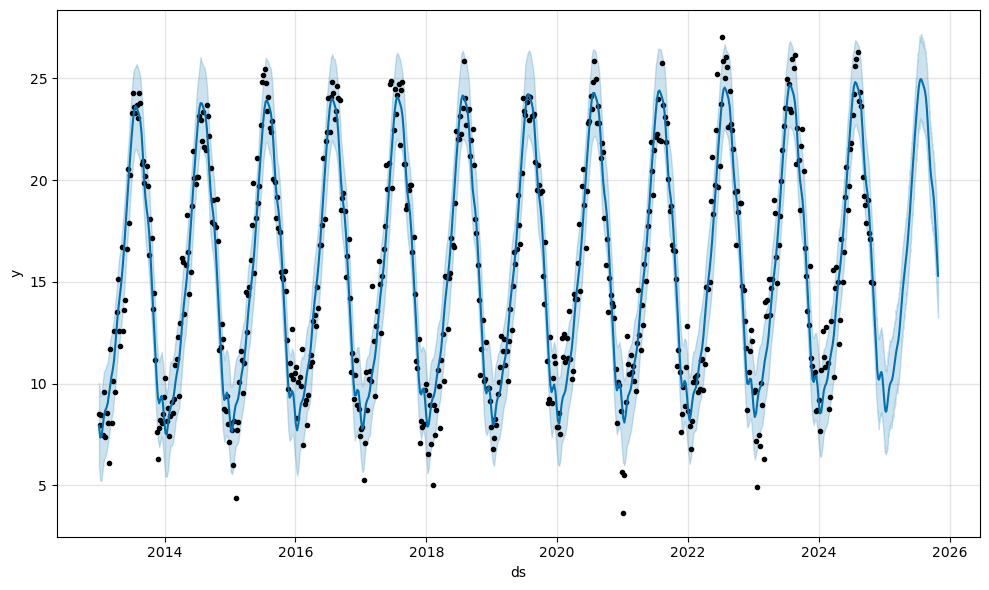

In [48]:
# Graficar usando Prophet
fig1 = m.plot(forecast_weekly)

# Mostrar la gráfica
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

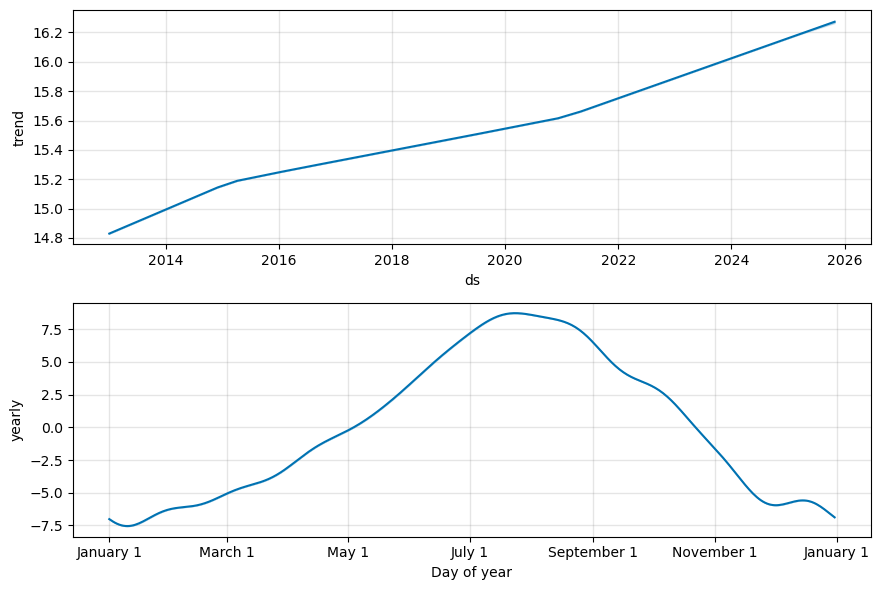

In [49]:
fig2 = m.plot_components(forecast_weekly)

# DIARIO:

In [51]:
df['dia'] = df['fecha'].dt.to_period('D').apply(lambda r: r.start_time)
df['dia']

0         2013-01-01
1         2013-01-01
2         2013-01-01
3         2013-01-01
4         2013-01-01
             ...    
7336000   2024-11-01
7336001   2024-11-01
7336002   2024-11-01
7336003   2024-11-01
7336004   2024-11-01
Name: dia, Length: 7336005, dtype: datetime64[ns]

In [52]:
df_daily = df.groupby("dia").agg({"tmed":"mean"}).reset_index()
df_daily

,dia,tmed
0,2013-01-01,8.240339
1,2013-01-02,7.839921
2,2013-01-03,7.954712
3,2013-01-04,8.583443
4,2013-01-05,9.326746
...,...,...
4318,2024-10-28,13.507628
4319,2024-10-29,14.864982
4320,2024-10-30,14.950358
4321,2024-10-31,15.548206


In [53]:
df_daily = preparar_data(df_daily,"dia","tmed")
df_daily

,ds,y
0,2013-01-01,8.240339
1,2013-01-02,7.839921
2,2013-01-03,7.954712
3,2013-01-04,8.583443
4,2013-01-05,9.326746
...,...,...
4318,2024-10-28,13.507628
4319,2024-10-29,14.864982
4320,2024-10-30,14.950358
4321,2024-10-31,15.548206


In [54]:
#MODELO

m = Prophet()
m.fit(df_daily)

13:03:21 - cmdstanpy - INFO - Chain [1] start processing
13:03:21 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
joblib.dump(forecast_daily, 'f_prophet_daily.pkl')

print("Modelo guardado con joblib")

NameError: name 'forecast_daily' is not defined

In [ ]:
future = m.make_future_dataframe(periods=365)
future.tail()

In [ ]:
forecast_daily = m.predict(future)
forecast_daily[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# Graficar usando Prophet
fig1 = m.plot(forecast_daily)

# Mostrar la gráfica
plt.show()

In [ ]:
fig2 = m.plot_components(forecast_daily)